<a href="https://colab.research.google.com/github/gregory-ch/shap_flex_porting/blob/main/shap_joint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Libraries installation

In [ ]:
!pip install catboost
!pip install shap
!pip install igraph
!pip install shapflex
!pip install causal-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###2. Data downloading

 source: [Data](https://github.com/ShawhinT/YouTube-Blog/blob/main/causal_discovery/df_causal_discovery.p), [Tutorial](https://towardsdatascience.com/causal-discovery-6858f9af6dcb)

In [ ]:
import pickle
import matplotlib.pyplot as plt
df = pickle.load( open( "df_causal_discovery.p", "rb") )

### 3. Setting a model to explain

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
data_to_explain = df.copy()
outcome_name = 'greaterThan50k'
outcome_col = pd.Series(data_to_explain.columns)[data_to_explain.columns==outcome_name].index[0]
X, y = data_to_explain.drop(outcome_name, axis=1), data_to_explain[outcome_name].values
model = CatBoostClassifier(iterations=1000)
model.fit(X, y, verbose=100)
def predict_function(model, data_to_explain):
  return pd.DataFrame(model.predict_proba(data_to_explain)[:, [0]])

Learning rate set to 0.043497
0:	learn: 0.6623482	total: 7.19ms	remaining: 7.19s
100:	learn: 0.4141735	total: 653ms	remaining: 5.81s
200:	learn: 0.4106785	total: 1.5s	remaining: 5.96s
300:	learn: 0.4079625	total: 2.3s	remaining: 5.35s
400:	learn: 0.4053425	total: 2.95s	remaining: 4.4s
500:	learn: 0.4030620	total: 4.22s	remaining: 4.21s
600:	learn: 0.4011586	total: 5.88s	remaining: 3.9s
700:	learn: 0.3995024	total: 7.57s	remaining: 3.23s
800:	learn: 0.3980119	total: 9.4s	remaining: 2.34s
900:	learn: 0.3966029	total: 11.2s	remaining: 1.23s
999:	learn: 0.3952973	total: 12.8s	remaining: 0us


###4. Non-causal case: symmetric shapley values, no prior knowledge

In [ ]:
from shapflex.shapflex import shapFlex_plus

explain, reference = data_to_explain.iloc[:300, :data_to_explain.shape[1]-1], data_to_explain.iloc[:, :data_to_explain.shape[1]-1]
exmpl_of_test = shapFlex_plus(explain, model, predict_function, target_features=pd.Series([
                                                                                         "age", "inRelationship", 
                                                                                         "hours-per-week", "hasGraduateDegree",
                                                                                         "isFemale", "isWhite"])
)
result = exmpl_of_test.forward()

Assembling a causal data to a format with which shap's beeswarm is able to deal

In [ ]:
from shap._explanation import Explanation
values = pd.DataFrame(result['shap_effect'].values.reshape(-1, 6), columns = result['feature_name'].unique()).values
base_values = np.array([result['shap_effect intercept'][0] for i in range(explain.shape[0])])
data = explain.values
shap_values_shapflex = Explanation(values, base_values=base_values, data=data, feature_names=result.loc[:5, 'feature_name'].values)

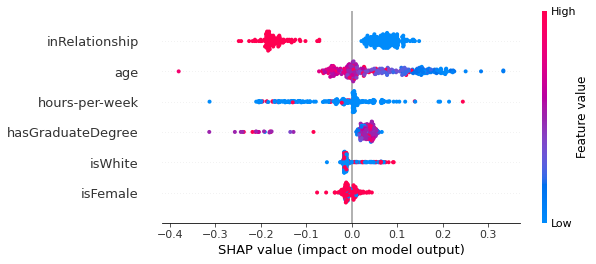

In [ ]:
import shap
shap.plots.beeswarm(shap_values=shap_values_shapflex )

###5. Building a causal graph, FCI algorithm.

  step 1: Use FCI without prior knowledge

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci
G = fci(df)

Starting Fast Adjacency Search.


  0%|          | 0/7 [00:00<?, ?it/s]

Finishing Fast Adjacency Search.
X1 --> X4
X1 --> X7
X2 --> X4
X7 --> X5


 step 2: turn off some nodes

In [ ]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
nodes = G[0].get_nodes()
bc = BackgroundKnowledge() \
            .add_forbidden_by_node(nodes[2], nodes[0]) \
            .add_forbidden_by_node(nodes[1], nodes[2]) \
            .add_forbidden_by_node(nodes[4], nodes[5]) \
            .add_forbidden_by_node(nodes[5], nodes[4]) \
            .add_forbidden_by_node(nodes[5], nodes[0]) \
            .add_forbidden_by_node(nodes[0], nodes[5]) \
            .add_forbidden_by_node(nodes[3], nodes[4]) \
            .add_forbidden_by_node(nodes[6], nodes[4]) \
            .add_forbidden_by_node(nodes[3], nodes[5]) \
            .add_forbidden_by_node(nodes[2], nodes[4]) \
            .add_forbidden_by_node(nodes[1], nodes[4]) \
            .add_required_by_node(nodes[1], nodes[5])

G2 = fci(df, background_knowledge=bc)

Starting Fast Adjacency Search.


  0%|          | 0/7 [00:00<?, ?it/s]

X1 --- X6 because it was forbidden by background background_knowledge.
X5 --- X6 because it was forbidden by background background_knowledge.
Finishing Fast Adjacency Search.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X5 --> X2
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X5 --> X3
Orienting edge (Knowledge): X5 --> X4
Orienting edge (Knowledge): X6 --> X4
Orienting edge (Knowledge): X5 --> X7
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X3
Orienting edge (Knowledge): X3 --> X2
Orienting edge (Knowledge): X5 --> X2
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X5 --> X3
Orienting edge (Knowledge): X5 --> X4
Orienting edge (Knowledge): X6 --> X4
Orienting edge (Knowledge): X5 --> X7
Finishing BK Orientation.
X3 --> X2
X2 --> X4
X2 --> X6
X6 --> X4
X4 --> X7


###6. Assembling a causal dataframe from a causal graph

In [ ]:
nodes = []
for edge in G2[1]:
  nodes.append([edge.get_node1().get_name(), edge.get_node2().get_name()])

names = {x:y for x, y in zip([
                              'X' + str(i) for i in range(1, 8)
], df.columns.values
)}

causal = pd.DataFrame()
causal['cause'] = pd.DataFrame(nodes)[0].apply(lambda x: names[x])
causal['effect'] = pd.DataFrame(nodes)[1].apply(lambda x: names[x])

We don't want to have an objective node in our graph. Also, though we turned off an edge 'hours-per-week' $\rightarrow$ 'isFemale' it somehow appeared in a graph. So, we have to delete it.

In [ ]:
causal_without_objective = causal.where(causal!='greaterThan50k').dropna(axis=0)
causal_without_objective = causal_without_objective.drop(6).reset_index(drop=True)

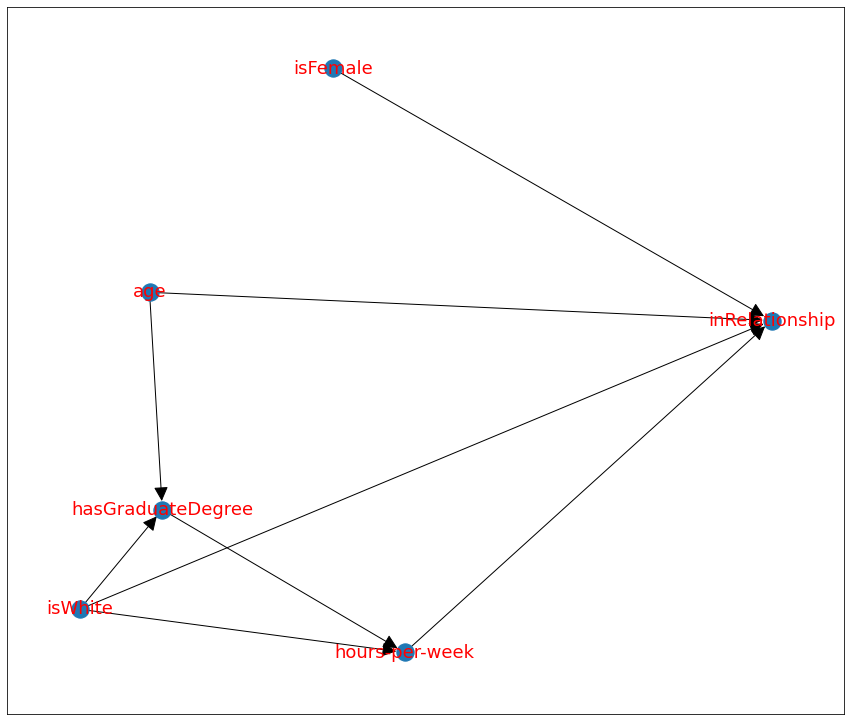

In [ ]:
import networkx as nx
fig = plt.figure(figsize=(15, 13))
nx.draw_networkx(nx.from_pandas_edgelist(causal_without_objective, source='cause', target='effect', create_using=nx.classes.digraph.DiGraph), font_size=18, font_color='r', arrowsize=30)

###7. Running a causal case

In [ ]:
exmpl_of_test = shapFlex_plus(explain, model, predict_function, target_features=pd.Series(
    ['age', 'hours-per-week', 'hasGraduateDegree', 'inRelationship',
       'isWhite', 'isFemale']), causal=causal_without_objective, causal_weights=[1. for i in range(causal_without_objective.shape[0])])
result = exmpl_of_test.forward()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
values = pd.DataFrame(result['shap_effect'].values.reshape(-1, 6), columns = result['feature_name'].unique()).values
base_values = np.array([result['shap_effect intercept'][0] for i in range(explain.shape[0])])
data = explain.values
shap_values_shapflex = Explanation(values, base_values=base_values, data=data, feature_names=result.loc[:5, 'feature_name'].values)

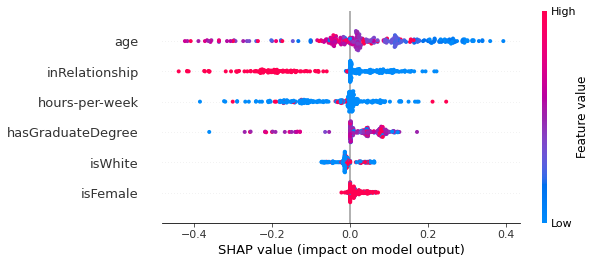

In [ ]:
shap.plots.beeswarm(shap_values=shap_values_shapflex )